In [2]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, pearsonr



In [3]:
# --- 1. Data Loading ---

uber_df = pd.read_excel("/content/Uber A_B testing.xlsx")

In [4]:
uber_df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,experiment_group
0,1,Strark,ios web,Paid,2016-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,treatment
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN,treatment
2,3,Wrouver,windows,Organic,2016-11-01 00:00:00,2016-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,treatment
3,4,Berton,android web,Referral,1/29/16,2016-03-02 00:00:00,2016-03-02 00:00:00,Toyota,Corolla,2016.0,2016-03-02 00:00:00,control
4,5,Strark,android web,Referral,2016-10-01 00:00:00,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN,treatment


In [5]:
# checking the shape

uber_df.shape

(54681, 12)

In [6]:
# viewing the columns
uber_df.columns

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'experiment_group'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         54681 non-null  int64         
 1   city_name                  54681 non-null  object        
 2   signup_os                  47824 non-null  object        
 3   signup_channel             54681 non-null  object        
 4   signup_date                54681 non-null  datetime64[ns]
 5   bgc_date                   32896 non-null  datetime64[ns]
 6   vehicle_added_date         13134 non-null  datetime64[ns]
 7   vehicle_make               13223 non-null  object        
 8   vehicle_model              13223 non-null  object        
 9   vehicle_year               13223 non-null  float64       
 10  first_completed_date       6137 non-null   datetime64[ns]
 11  experiment_group           54681 non-null  object        
 12  has_

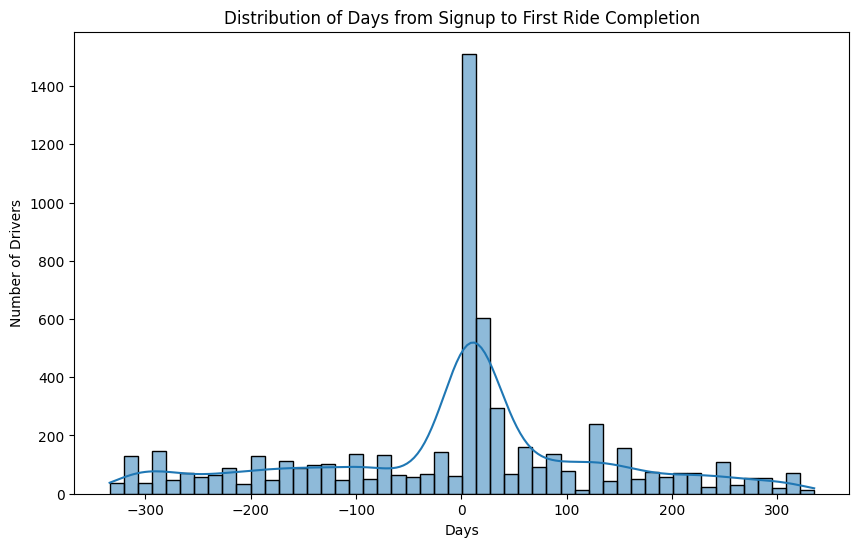

In [17]:
# --- 2. Data Cleaning and Preprocessing ---

# Convert date columns to datetime objects
date_columns = ['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']
for col in date_columns:
    uber_df[col] = pd.to_datetime(uber_df[col], errors='coerce') # 'coerce' turns unparseable dates into NaT

# Handle 'NA' strings and empty strings in categorical columns by replacing them with NaN
uber_df['signup_os'] = uber_df['signup_os'].replace('NA', np.nan).replace('', np.nan)
uber_df['signup_channel'] = uber_df['signup_channel'].replace('NA', np.nan).replace('', np.nan)
uber_df['city_name'] = uber_df['city_name'].replace('', np.nan) # Handle empty strings for city_name

# Create a binary column for 'first_ride_completion'
# 1 if first_completed_date is not null (ride completed), 0 otherwise
uber_df['has_completed_first_ride'] = uber_df['first_completed_date'].notna().astype(int)

# Calculate time differences in days for onboarding funnel analysis
uber_df['signup_to_bgc_days'] = (uber_df['bgc_date'] - uber_df['signup_date']).dt.days
uber_df['bgc_to_vehicle_add_days'] = (uber_df['vehicle_added_date'] - uber_df['bgc_date']).dt.days
uber_df['signup_to_first_ride_days'] = (uber_df['first_completed_date'] - uber_df['signup_date']).dt.days

# Calculate vehicle age based on a reference year (assuming 2016 as current data collection year)
current_year = pd.to_datetime('2016-01-01').year # Or the latest year in your data
uber_df['vehicle_age'] = current_year - uber_df['vehicle_year']
# Set vehicle_age to NaN if vehicle_year was missing
uber_df.loc[uber_df['vehicle_year'].isna(), 'vehicle_age'] = np.nan


# Display essential information after cleaning

uber_df.info() # This will print a summary of the DataFrame including dtypes and non-null counts


print("\nMissing values count after cleaning (top 10 columns with most NaNs):")
print(uber_df.isnull().sum().sort_values(ascending=False).head(10)) # Shows count of missing values per column


# --- 3. Visualization ---
plt.figure(figsize=(10, 6))
sns.histplot(uber_df['signup_to_first_ride_days'].dropna(), bins=50, kde=True)
plt.title('Distribution of Days from Signup to First Ride Completion')
plt.xlabel('Days')
plt.ylabel('Number of Drivers')
plt.show()

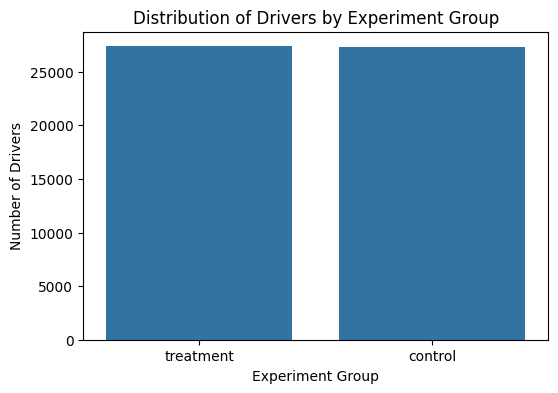

In [8]:
# --- 3. Exploratory Data Analysis (EDA) ---

# Distribution of Experiment Groups


plt.figure(figsize=(6, 4))
sns.countplot(x='experiment_group', data= uber_df)
plt.title('Distribution of Drivers by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Number of Drivers')
plt.show()



In [9]:
# Primary Metric: First Ride Completion Rate by Experiment Group

completion_rate_by_group = uber_df.groupby('experiment_group')['has_completed_first_ride'].mean() * 100
print("\nFirst Ride Completion Rate by Experiment Group (%):")
print(completion_rate_by_group)


First Ride Completion Rate by Experiment Group (%):
experiment_group
control      11.310875
treatment    11.135874
Name: has_completed_first_ride, dtype: float64


In [11]:

from statsmodels.stats.proportion import proportions_ztest

# --- Data Preparation ---
# Load the dataset
uber_df = pd.read_excel('/content/Uber A_B testing.xlsx')

# Create a binary column for 'first_ride_completion'
uber_df['has_completed_first_ride'] = uber_df['first_completed_date'].notna().astype(int)

# --- A/B Test Analysis ---
# Group the data by experiment group and get the success count and total count
summary_df = uber_df.groupby('experiment_group')['has_completed_first_ride'].agg(['sum', 'count'])
summary_df.columns = ['successes', 'total_trials']

# Extract the values needed for the Z-test
successes = np.array(summary_df['successes'])
total_trials = np.array(summary_df['total_trials'])

# Perform the two-sample proportion Z-test
z_stat, p_value = proportions_ztest(successes, total_trials)

print("--- A/B Test Results (Proportion Z-Test) ---")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

--- A/B Test Results (Proportion Z-Test) ---
Z-statistic: 0.6482
P-value: 0.5168


/tmp/ipython-input-3409402895.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rate_by_group.index, y=completion_rate_by_group.values, palette='viridis')


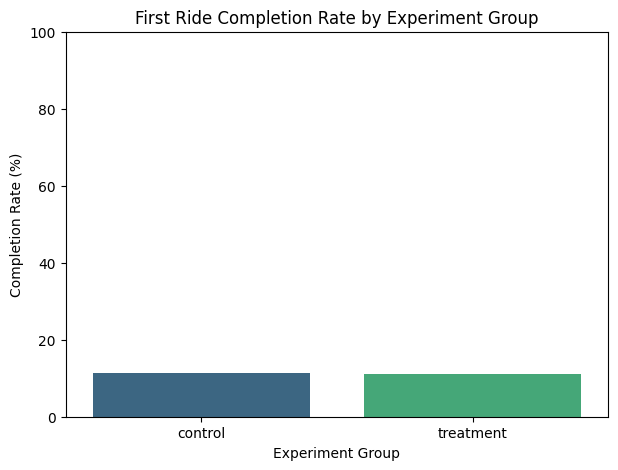

In [24]:
# Visualization of A/B Test Results
completion_rate_by_group = uber_df.groupby('experiment_group')['has_completed_first_ride'].mean() * 100
plt.figure(figsize=(7, 5))
sns.barplot(x=completion_rate_by_group.index, y=completion_rate_by_group.values, palette='viridis')
plt.title('First Ride Completion Rate by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Completion Rate (%)')
plt.ylim(0, 100)
plt.show()

In [13]:
# # Question 4:

# First Ride Completion Rate by Signup Channel
completion_rate_by_channel = uber_df.groupby('signup_channel')['has_completed_first_ride'].mean() * 100
print("\n--- First Ride Completion Rate by Signup Channel (%) ---")
print(completion_rate_by_channel)


--- First Ride Completion Rate by Signup Channel (%) ---
signup_channel
Organic      9.011693
Paid         6.190993
Referral    19.894895
Name: has_completed_first_ride, dtype: float64


In [14]:
# Question 4:

# Create a contingency table (cross-tabulation) of the two categorical variables
contingency_table_channel = pd.crosstab(uber_df['signup_channel'], uber_df['has_completed_first_ride'])

# Perform the Chi-square test
if not contingency_table_channel.empty and contingency_table_channel.shape[0] > 1 and contingency_table_channel.shape[1] > 1:
    chi2_channel, p_value_channel, dof_channel, expected_channel = chi2_contingency(contingency_table_channel)

    print(f"Chi-square Statistic (Signup Channel vs. First Ride): {chi2_channel:.2f}")
    print(f"P-value (Signup Channel vs. First Ride): {p_value_channel:.4f}")

    alpha = 0.05
    if p_value_channel < alpha:
        print(f"Conclusion: Reject null hypothesis. There is a statistically significant difference in first ride completion rates among drivers who signed up through different channels.")
    else:
        print(f"Conclusion: Fail to reject null hypothesis. There is no statistically significant difference in first ride completion rates among drivers who signed up through different channels.")
else:
    print("Cannot perform Chi-square test: Not enough valid data in 'signup_channel' or 'has_completed_first_ride'.")

Chi-square Statistic (Signup Channel vs. First Ride): 1981.19
P-value (Signup Channel vs. First Ride): 0.0000
Conclusion: Reject null hypothesis. There is a statistically significant difference in first ride completion rates among drivers who signed up through different channels.


/tmp/ipython-input-92270169.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=completion_rate_by_channel.index, y=completion_rate_by_channel.values, palette='plasma')


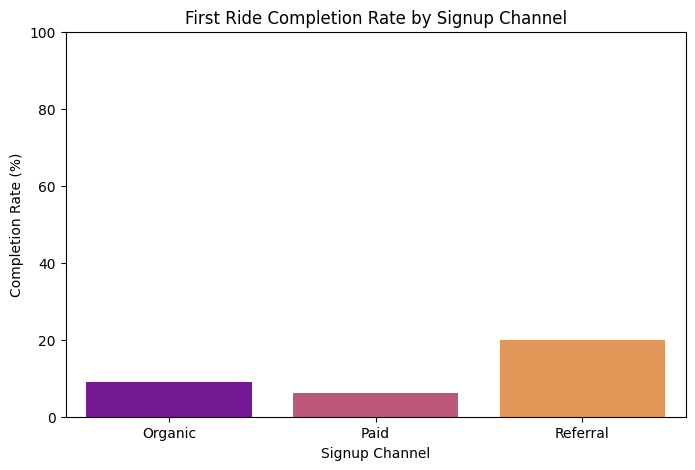

In [15]:
# Visualisation

plt.figure(figsize=(8, 5))
sns.barplot(x=completion_rate_by_channel.index, y=completion_rate_by_channel.values, palette='plasma')
plt.title('First Ride Completion Rate by Signup Channel')
plt.xlabel('Signup Channel')
plt.ylabel('Completion Rate (%)')
plt.ylim(0, 100)
plt.show()


In [18]:
# Question 6:

from scipy.stats import f_oneway

# Filter the DataFrame for drivers who completed a first ride and have non-missing vehicle age and city name
uber_df_completed_rides_filtered = uber_df[(uber_df['has_completed_first_ride'] == 1) & uber_df['vehicle_age'].notna() & uber_df['city_name'].notna()]

# Group the filtered data by city and extract the vehicle ages into a list of arrays
city_vehicle_ages_for_anova = [group['vehicle_age'].dropna() for city, group in uber_df_completed_rides_filtered.groupby('city_name')]

# Filter out groups with fewer than 2 data points, which are invalid for ANOVA
valid_anova_groups = [g for g in city_vehicle_ages_for_anova if len(g) > 1]

if len(valid_anova_groups) >= 2: # ANOVA requires at least two groups with at least 2 observations each
    f_stat_anova, p_value_anova = f_oneway(*valid_anova_groups)
    print(f"ANOVA F-statistic (Vehicle Age across Cities for Completed Rides): {f_stat_anova:.2f}")
    print(f"ANOVA P-value (Vehicle Age across Cities for Completed Rides): {p_value_anova:.4f}")

    alpha = 0.05
    if p_value_anova < alpha:
        print(f"Conclusion: Reject null hypothesis. There is a statistically significant difference in the mean vehicle ages for drivers who completed their first ride across different cities.")
    else:
        print(f"Conclusion: Fail to reject null hypothesis. There is no statistically significant difference in the mean vehicle ages for drivers who completed their first ride across different cities.")
else:
    print("Not enough unique cities with sufficient data to perform ANOVA for vehicle age.")

ANOVA F-statistic (Vehicle Age across Cities for Completed Rides): 19.10
ANOVA P-value (Vehicle Age across Cities for Completed Rides): 0.0000
Conclusion: Reject null hypothesis. There is a statistically significant difference in the mean vehicle ages for drivers who completed their first ride across different cities.


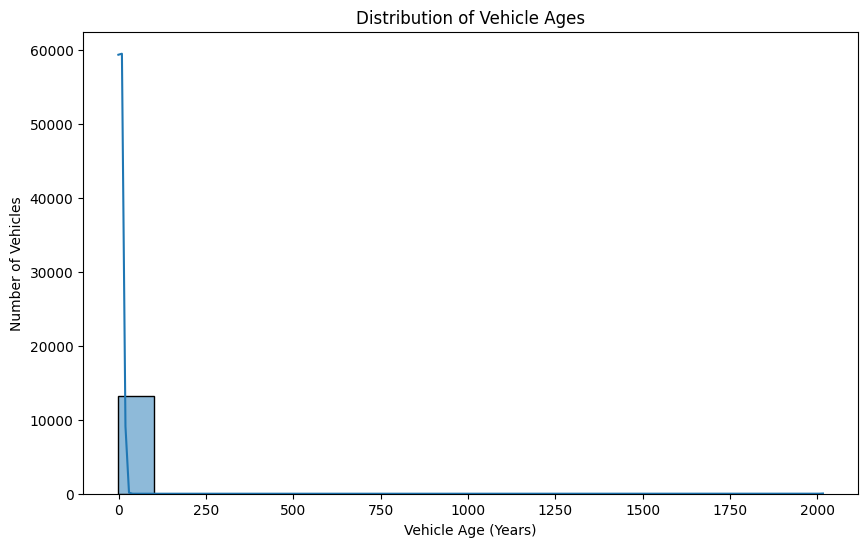

In [19]:
# Distribution of Vehicle Ages (for those with vehicle data)
plt.figure(figsize=(10, 6))
sns.histplot(uber_df['vehicle_age'].dropna(), bins=20, kde=True)
plt.title('Distribution of Vehicle Ages')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Number of Vehicles')
plt.show()

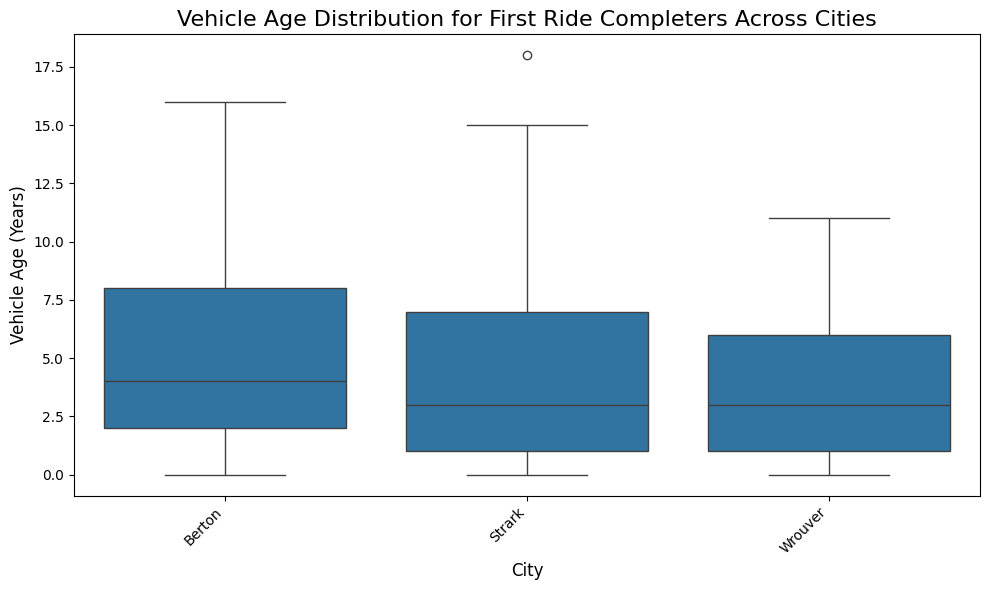

In [20]:

# --- Visualization Code ---
plt.figure(figsize=(10, 6))
sns.boxplot(x='city_name', y='vehicle_age', data=uber_df_completed_rides_filtered)
plt.title('Vehicle Age Distribution for First Ride Completers Across Cities', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Vehicle Age (Years)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Question 8:


# Correlation between signup_to_bgc_days and bgc_to_vehicle_add_days
# Filter out NaNs for correlation calculation


from scipy.stats import pearsonr

# Filter out NaNs for correlation calculation
filtered_corr_df_onboarding = uber_df[['signup_to_bgc_days', 'bgc_to_vehicle_add_days']].dropna()

if not filtered_corr_df_onboarding.empty and len(filtered_corr_df_onboarding) > 1:
    correlation_onboarding, p_value_corr = pearsonr(filtered_corr_df_onboarding['signup_to_bgc_days'], filtered_corr_df_onboarding['bgc_to_vehicle_add_days'])
    print(f"Pearson Correlation Coefficient: {correlation_onboarding:.4f}")
    print(f"P-value for Correlation: {p_value_corr:.4f}")

    alpha = 0.05
    if p_value_corr < alpha:
        print(f"Conclusion: Reject null hypothesis. There is a statistically significant correlation between time from signup to BGC completion and BGC to vehicle addition.")
    else:
        print(f"Conclusion: Fail to reject null hypothesis. No statistically significant correlation between time from signup to BGC completion and BGC to vehicle addition.")
else:
    print("Not enough data points to calculate correlation for onboarding times.")


Pearson Correlation Coefficient: -0.3565
P-value for Correlation: 0.0000
Conclusion: Reject null hypothesis. There is a statistically significant correlation between time from signup to BGC completion and BGC to vehicle addition.


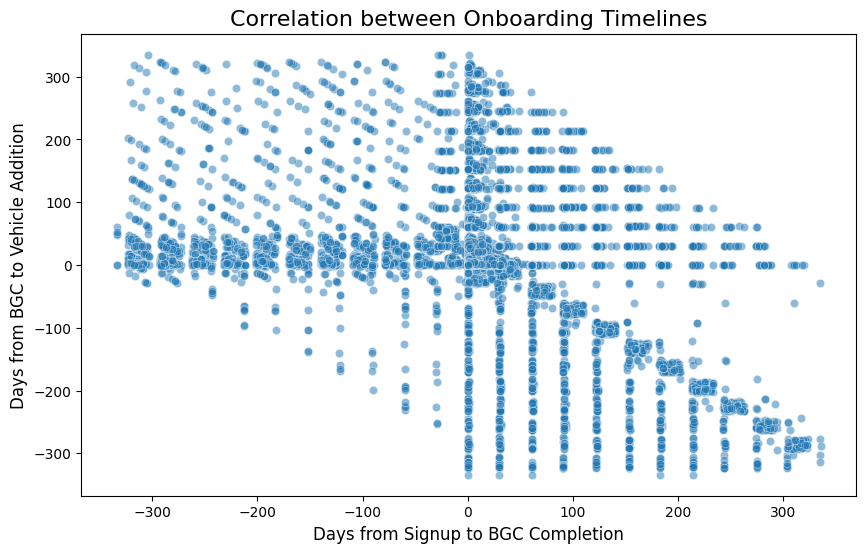

In [22]:


# --- Visualization Code ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='signup_to_bgc_days', y='bgc_to_vehicle_add_days', data=filtered_corr_df_onboarding, alpha=0.5)
plt.title('Correlation between Onboarding Timelines', fontsize=16)
plt.xlabel('Days from Signup to BGC Completion', fontsize=12)
plt.ylabel('Days from BGC to Vehicle Addition', fontsize=12)
plt.show()